
# No MLOps
We are just building a quick prototype model or, say, PoC for our objective. We do not have following for this stage

- No experiment tracking
- No model management
- No Model Registry or Deployment

We are currently logging the model performance metrics and brief info manually as below. It becomes chaotic after a point to manage experiments manually, no reproducibilty as we are not tracking model parameters, hyper-params etc. No lineage is being tracked.

### Experiments:
- With outliers for trip-distance and trip-duration throws the Linear regression Model, it predicts same time for almost all trips i.e. 16 minutes. That gives us an RMSE of around ~10 Mins.
- Removing outliers gives us RMSE around 6.5 minutes for both train and test.
- When we add pick-up and drop-location in the model, it reduced the train and test RMSE to 5.5 minutes.
- When we add the combination of pick-up and drop location, RMSE improves to 4.9-5 minutes

### EDA
- Few trips has date out of the range for the file
- Passenger count is null for many rows not sure what does that mean
- No missings for the pickup location, drop off location
- Seems trips from VendorID=7 have duration=0
- "Trip distance" also have outliers and after removing those, the correlation between duration and distance becomes significantly high.

#### The notebook will run on defaul ipykernel, to connect it to the conda enviornment:
- First install the ipykernel in the enviornment, activate the env and run following in commandline "conda install -c anaconda ipykernel"
- Attach this kernel to jupyter notebooks "python -m ipykernel install --user --name=env_name

In [28]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [29]:
os.chdir("/Users/vss/Personal/Git/NYC_Taxi_Trip_Duration_Prediction/")
data_dir = "./data/raw_data/"
file_2025_03 = "{}yellow_tripdata_2025-03.parquet".format(data_dir)
file_2025_04 = "{}yellow_tripdata_2025-04.parquet".format(data_dir)
file_2025_05 = "{}yellow_tripdata_2025-05.parquet".format(data_dir)


### Utilities

In [32]:

def load_parquet_data(file: str) -> pd.DataFrame:
    '''
    Loads parquet data
    '''
    print("Loading data from: ", file)
    data = pd.read_parquet(file)
    print("\n======= SIZE =========")
    print(data.shape)
    print("\n======= DTYPES =========")
    print(data.dtypes)
    print("\n======= SUMMARY =========")
    print(data.describe())
    
    return data


def calculate_target_variable(data: pd.DataFrame) -> pd.DataFrame:
    '''
    calcualte the trip duration from pickup time and drop time
    '''
    data['trip_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
    data['trip_duration'] = data['trip_duration'].apply(lambda diff: diff.total_seconds()/60)
    print(data['trip_duration'].describe())
    print(data['trip_duration'].head())
    return data


def get_clean_data(data: pd.DataFrame) -> pd.DataFrame:
    flag1 = (data['trip_duration'] >= 1) & (data['trip_duration'] <= 60)
    flag2 = (data['trip_distance'] >= 0.2) & (data['trip_distance'] <= 100)
    print(flag1.sum())
    print((flag1&flag2).sum())
    data = data[flag1&flag2].reset_index(drop=True)
    return data


def filter_outliers(data: pd.DataFrame) -> pd.DataFrame:
    flag1 = (data['trip_duration'] >= 1) & (data['trip_duration'] <= 60)
    flag2 = (data['trip_distance'] >= 0.2) & (data['trip_distance'] <= 100)
    print(flag1.sum())
    print((flag1&flag2).sum())
    data = data[flag1&flag2].reset_index(drop=True)
    return data

from enum import Enum
class Transform_Fun_Options(str, Enum):
    LOG = 'log'
    SQRT = 'sqrt'
    
    
def transform_numeric_features(data: pd.DataFrame, features: list, transformation_fun: Transform_Fun_Options):
    if transformation_fun == Transform_Fun_Options.LOG:
        data[features] = np.log(data[features]+1)
    return data

### Load Data

In [33]:
train_data = load_parquet_data(file_2025_03)
test_data = load_parquet_data(file_2025_04)


print("\n======= SNAPSHOT =========")
train_data.head(10)

Loading data from:  ./data/raw_data/yellow_tripdata_2025-03.parquet

======= SIZE =========
(4145257, 20)

======= DTYPES =========
VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
cbd_congestion_fee              float64
dtype: object

======= SUMMARY =========
           VendorID        

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-03-01 00:17:16,2025-03-01 00:25:52,1.0,0.90,1.0,N,140,236,1,7.9,3.50,0.5,2.60,0.0,1.0,15.50,2.5,0.0,0.00
1,1,2025-03-01 00:37:38,2025-03-01 00:43:51,1.0,0.60,1.0,N,140,262,1,6.5,3.50,0.5,2.30,0.0,1.0,13.80,2.5,0.0,0.00
2,2,2025-03-01 00:24:35,2025-03-01 00:39:49,1.0,1.94,1.0,N,161,68,1,14.9,1.00,0.5,5.16,0.0,1.0,25.81,2.5,0.0,0.75
3,2,2025-03-01 00:56:16,2025-03-01 01:01:35,2.0,0.95,1.0,N,231,13,1,7.2,1.00,0.5,2.59,0.0,1.0,15.54,2.5,0.0,0.75
4,1,2025-03-01 00:01:44,2025-03-01 00:10:00,1.0,1.50,1.0,N,163,236,1,8.6,4.25,0.5,2.85,0.0,1.0,17.20,2.5,0.0,0.75
5,1,2025-03-01 00:11:57,2025-03-01 00:28:33,0.0,2.00,1.0,N,166,74,1,16.3,1.00,0.5,2.00,0.0,1.0,20.80,0.0,0.0,0.00
6,2,2025-03-01 00:22:35,2025-03-01 00:34:06,2.0,3.27,1.0,N,88,79,1,17.0,1.00,0.5,4.55,0.0,1.0,27.30,2.5,0.0,0.75
7,2,2025-03-01 00:37:22,2025-03-01 00:45:03,1.0,0.95,1.0,N,114,107,1,8.6,1.00,0.5,2.00,0.0,1.0,16.35,2.5,0.0,0.75
8,2,2025-02-28 23:50:41,2025-03-01 00:03:51,1.0,2.09,1.0,N,79,186,1,13.5,1.00,0.5,3.85,0.0,1.0,23.10,2.5,0.0,0.75
9,2,2025-03-01 00:06:48,2025-03-01 00:18:44,1.0,1.43,1.0,N,186,107,1,12.1,1.00,0.5,3.57,0.0,1.0,21.42,2.5,0.0,0.75


### Create the Target

In [35]:
train_data = calculate_target_variable(train_data)
test_data = calculate_target_variable(test_data)

count    4.145257e+06
mean     1.598918e+01
std      2.729762e+01
min     -3.431667e+01
25%      7.716667e+00
50%      1.246667e+01
75%      1.946667e+01
max      6.275833e+03
Name: trip_duration, dtype: float64
0     8.600000
1     6.216667
2    15.233333
3     5.316667
4     8.266667
Name: trip_duration, dtype: float64
count    3.970553e+06
mean     1.662804e+01
std      2.950762e+01
min     -1.205833e+02
25%      7.883333e+00
50%      1.293333e+01
75%      2.038333e+01
max      1.488077e+04
Name: trip_duration, dtype: float64
0    26.316667
1    10.733333
2    11.083333
3     4.316667
4    16.033333
Name: trip_duration, dtype: float64


### Clean and filter the data

In [36]:
train_data['PU_DO'] = train_data['PULocationID'].astype('str') + '_' + train_data['DOLocationID'].astype('str')
test_data['PU_DO'] = test_data['PULocationID'].astype('str') + '_' + test_data['DOLocationID'].astype('str')
print(train_data['PU_DO'].head())
print(train_data['PU_DO'].nunique())
Freq = train_data['PU_DO'].value_counts().reset_index()
print(Freq.head())
print(train_data['PU_DO'].value_counts().value_counts())

0    140_236
1    140_262
2     161_68
3     231_13
4    163_236
Name: PU_DO, dtype: object
37950
     PU_DO  count
0  237_236  23653
1  236_237  20392
2  237_237  16443
3  236_236  16342
4  161_237  11366
count
1        8364
2        4737
3        3178
4        2237
5        1712
         ... 
1773        1
752         1
751         1
750         1
23653       1
Name: count, Length: 1776, dtype: int64


In [37]:
# Make this rare trip combination as 'other'
rare_trips  = set(Freq.loc[Freq['count'] <=5, 'PU_DO'])
train_data['PU_DO'] = np.where(train_data['PU_DO'].isin(rare_trips), 'Other', train_data['PU_DO'])

print(train_data['PU_DO'].nunique())

17723


In [41]:
train_data.groupby('PU_DO').agg({'PU_DO':'count', 'trip_duration':'mean', 'trip_distance':'mean'})

,PU_DO,trip_duration,trip_distance
PU_DO,,,
100_1,182,41.797894,17.148681
100_10,9,50.372222,15.751111
100_100,1289,4.660499,0.361885
100_106,8,32.433333,7.820000
100_107,1008,12.287087,1.584137
...,...,...,...
9_16,8,8.572917,1.240000
9_171,7,8.659524,1.434286
9_9,17,5.324510,0.822353


In [22]:

train_data_filtered = filter_outliers(train_data)
test_data_filtered = filter_outliers(test_data)
print(train_data_filtered.shape)
print(test_data_filtered.shape)
print(train_data_filtered['trip_duration'].describe())

4022210
3922659
3826766
3744054
(3922659, 22)
(3744054, 22)
count    3.922659e+06
mean     1.498906e+01
std      1.008381e+01
min      1.000000e+00
25%      7.866667e+00
50%      1.246667e+01
75%      1.916667e+01
max      6.000000e+01
Name: trip_duration, dtype: float64


In [23]:
num_features = ['trip_distance']
cat_features = ['PU_DO']#['PULocationID', 'DOLocationID']
features = num_features + cat_features
target = 'trip_duration'

# Transform features
#features_to_transform = num_features + [target]
#train_data_filtered = transform_numeric_features(train_data_filtered, features_to_transform, Transform_Fun_Options.LOG)
#test_data = transform_numeric_features(test_data, features_to_transform, Transform_Fun_Options.LOG)
#test_data_filtered = transform_numeric_features(test_data_filtered, features_to_transform, Transform_Fun_Options.LOG)

# Change all categorical variables to strings
train_data_filtered[cat_features] = train_data_filtered[cat_features].astype('str')
test_data_filtered[cat_features] = test_data_filtered[cat_features].astype('str')
test_data[cat_features] = test_data[cat_features].astype('str')

# Change 
train_data_filtered_dict = train_data_filtered[features].to_dict(orient='records')
test_data_filtered_dict = test_data_filtered[features].to_dict(orient='records')
test_data_dict = test_data[features].to_dict(orient='records')


In [24]:
train_data_filtered_dict[0]

{'trip_distance': 0.9, 'PU_DO': '140_236'}

In [29]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer()

X = dv.fit_transform(train_data_filtered_dict)
y = train_data_filtered[target].values
print(X.shape)

X_test_filtered = dv.transform(test_data_filtered_dict)
y_test_filtered = test_data_filtered[target].values

X_test = dv.transform(test_data_dict)
y_test = test_data[target].values

(3922659, 35309)


### Train the model

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)
print(model.coef_, model.intercept_)

[-8.87691968  1.38374227 -7.51563454 ... -6.10421363 -8.08219202
  1.61811257] 13.943194764338177


### Make Predictions

In [27]:
import numpy as np
y_predictions = model.predict(X)
y_test_predictions = model.predict(X_test)
y_test_filtered_predictions = model.predict(X_test_filtered)

print(np.round(X[0:10],4))
print(np.round(y[0:10],4))
print(np.round(y_predictions[0:10],4))
print(np.round(y_test[0:10],4))
print(np.round(y_test_predictions[0:10],4))
print(np.round(y_test_filtered[0:10],4))
print(np.round(y_test_filtered_predictions[0:10],4))


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 20 stored elements and shape (10, 35309)>
  Coords	Values
  (0, 5375)	1.0
  (0, 35308)	0.9
  (1, 5401)	1.0
  (1, 35308)	0.6
  (2, 8701)	1.0
  (2, 35308)	1.9400000000000002
  (3, 18717)	1.0
  (3, 35308)	0.9500000000000001
  (4, 9064)	1.0
  (4, 35308)	1.5
  (5, 9629)	1.0
  (5, 35308)	2.0
  (6, 33713)	1.0
  (6, 35308)	3.27
  (7, 1488)	1.0
  (7, 35308)	0.9500000000000001
  (8, 32043)	1.0
  (8, 35308)	2.0900000000000003
  (9, 12236)	1.0
  (9, 35308)	1.4300000000000002
[ 8.6     6.2167 15.2333  5.3167  8.2667 16.6    11.5167  7.6833 13.1667
 11.9333]
[ 8.8504  5.1246 15.4003  6.9413 10.8305 13.951  13.883   8.1135 14.2115
 10.8787]
[26.3167 10.7333 11.0833  4.3167 16.0333  0.     19.55   16.9167  1.5
 29.65  ]
[34.6474 13.8044 17.038   5.5329  7.4224 10.3725 22.5854 23.1736  4.5795
 42.6361]
[26.3167 10.7333 11.0833  4.3167 16.0333 19.55   16.9167  1.5    29.65
  5.8833]
[34.6474 13.8044 17.038   5.5329  7.4224 22.5854 23.1736  4.

### Score Predictions

In [28]:
from sklearn.metrics import root_mean_squared_error
train_error = root_mean_squared_error(y, y_predictions)
test_error = root_mean_squared_error(y_test, y_test_predictions)
test_filtered_error = root_mean_squared_error(y_test_filtered, y_test_filtered_predictions)
print("Train Error:", train_error)
print("Test Error:", test_error)
print("Test Error:", test_filtered_error)


Train Error: 4.874724590750923
Test Error: 1071.8615540959213
Test Error: 5.3162491333348765


In [31]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)

/var/folders/1x/7vkpqdrs6h1_fwl7vg5pm4sc0000gn/T/ipykernel_28613/373014024.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.clip(y_predictions,0.25,60), label='prediction')
/var/folders/1x/7vkpqdrs6h1_fwl7vg5pm4sc0000gn/T/ipykernel_28613/373014024.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns

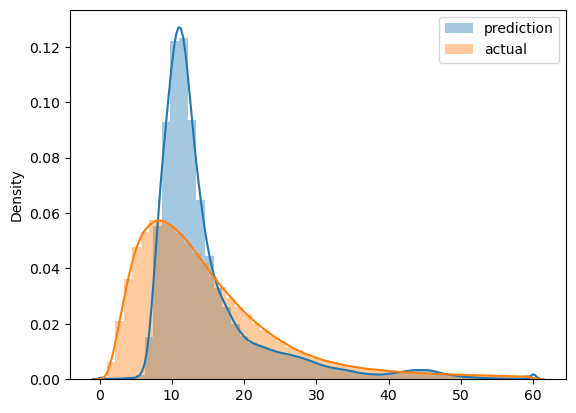

In [20]:

sns.distplot(np.clip(y_predictions,0.25,60), label='prediction')
sns.distplot(y, label='actual')
plt.legend()